In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
from sys import platform
is_linux = (platform == "linux" or platform == "linux2")

from glob import glob
from os import listdir, mkdir, getcwd, remove
from os.path import isfile, join, basename, isdir

from analysis.convert_directory import convert_directory
from analysis.split_event_tree import split_event_tree,ttype_column
from analysis.calc import calc_llr_dtf_delta
from analysis.import_data import import_data,filter_data,combine_columns

In [16]:
mcp_raw = import_data("/nfs/dust/ilc/user/bliewert/fullflow_v3/comparison/npy/mcparticle/compare_mcparticle.npy")
reco_raw = import_data("/nfs/dust/ilc/user/bliewert/fullflow_v3/comparison/npy/reco/compare_reco.npy")
tjmr_raw = import_data("/nfs/dust/ilc/user/bliewert/fullflow_v3/comparison/npy/truejet_matchingreco/compare_truejet_matchingreco.npy")
tjt_raw = import_data("/nfs/dust/ilc/user/bliewert/fullflow_v3/comparison/npy/truejet_true/compare_truejet_true.npy")
tjs_raw = import_data("/nfs/dust/ilc/user/bliewert/fullflow_v3/comparison/npy/truejet_seen/compare_truejet_seen.npy")

In [21]:
data = {
    "mcp": calc_llr_dtf_delta(filter_data(mcp_raw)),
    "reco": calc_llr_dtf_delta(filter_data(reco_raw)),
    "tjmr": calc_llr_dtf_delta(filter_data(tjmr_raw)),
    "tjt": calc_llr_dtf_delta(filter_data(tjt_raw)),
    "tjs": calc_llr_dtf_delta(filter_data(tjs_raw))
}

In [51]:
def plot_nll_llr_dtf_delta(data:Dict[str,pd.DataFrame], fig_path:Optional[str] = None):
    global prod_plot_mode
    #if prod_plot_mode:
    #    from analysis.plot_root import plot_hist
    #else:
    #    from analysis.plot_matplotlib import plot_hist
    
    fig, axes = plt.subplots(len(data.keys()), 3, figsize=(6*len(data.keys()), 7*3))
    order = ["mcp", "tjt", "tjs", "tjmr", "reco"]
    for i in range(len(order)):
        name = order[i]
        df = data[name]
        
        ax1, ax2, ax3 = axes[i]
        
        true_zzh = df[(df["is_zzh"] == 1) & (df["zhh_sigma"] > 0) & (df["zzh_sigma"] > 0)].copy()
        true_zhh = df[(df["is_zhh"] == 1) & (df["zhh_sigma"] > 0) & (df["zzh_sigma"] > 0)].copy()
        
        true_zzh.reset_index(drop=True,inplace=True)
        true_zhh.reset_index(drop=True,inplace=True)
        
        plot_hist(true_zhh, x = ["zhh_nll", "zzh_nll"], title="ZHH event data", normalize=True, labels=["ZHH {}".format(name), "ZZH".format(name)], xlabel="nll", ax=ax1)
        plot_hist(true_zhh, x = ["zhh_nll", "zzh_nll"], title="ZHH event data", normalize=True, labels=["ZHH {}".format(name), "ZZH".format(name)], xlabel="nll", ax=ax2)
        
        llr = combine_columns({ "zhh_llr": true_zhh["llr"], "zzh_llr": true_zzh["llr"] })
        plot_hist(llr, x = ["zhh_llr", "zzh_llr"], labels=["ZHH event data", "ZZH event data"], title="LLR: {}".format(name), normalize=True, xlabel="llr", ax=ax3)
        
    if fig_path is not None:
        fig.savefig(fig_path)
    else:
        plt.show()
        
    plt.close(fig)

In [52]:
def plot_llr_dtf_delta(data, name):
    true_zzh = data[(data["is_zzh"] == 1) & (data["zhh_sigma"] > 0) & (data["zzh_sigma"] > 0)].copy()
    true_zhh = data[(data["is_zhh"] == 1) & (data["zhh_sigma"] > 0) & (data["zzh_sigma"] > 0)].copy()

    true_zzh.reset_index(drop=True,inplace=True)
    true_zhh.reset_index(drop=True,inplace=True)

    plot_hist(true_zhh, x = ["zhh_nll", "zzh_nll"], title="ZHH event data", normalize=True, labels=["ZHH {}", "ZZH"], xlabel="nll")

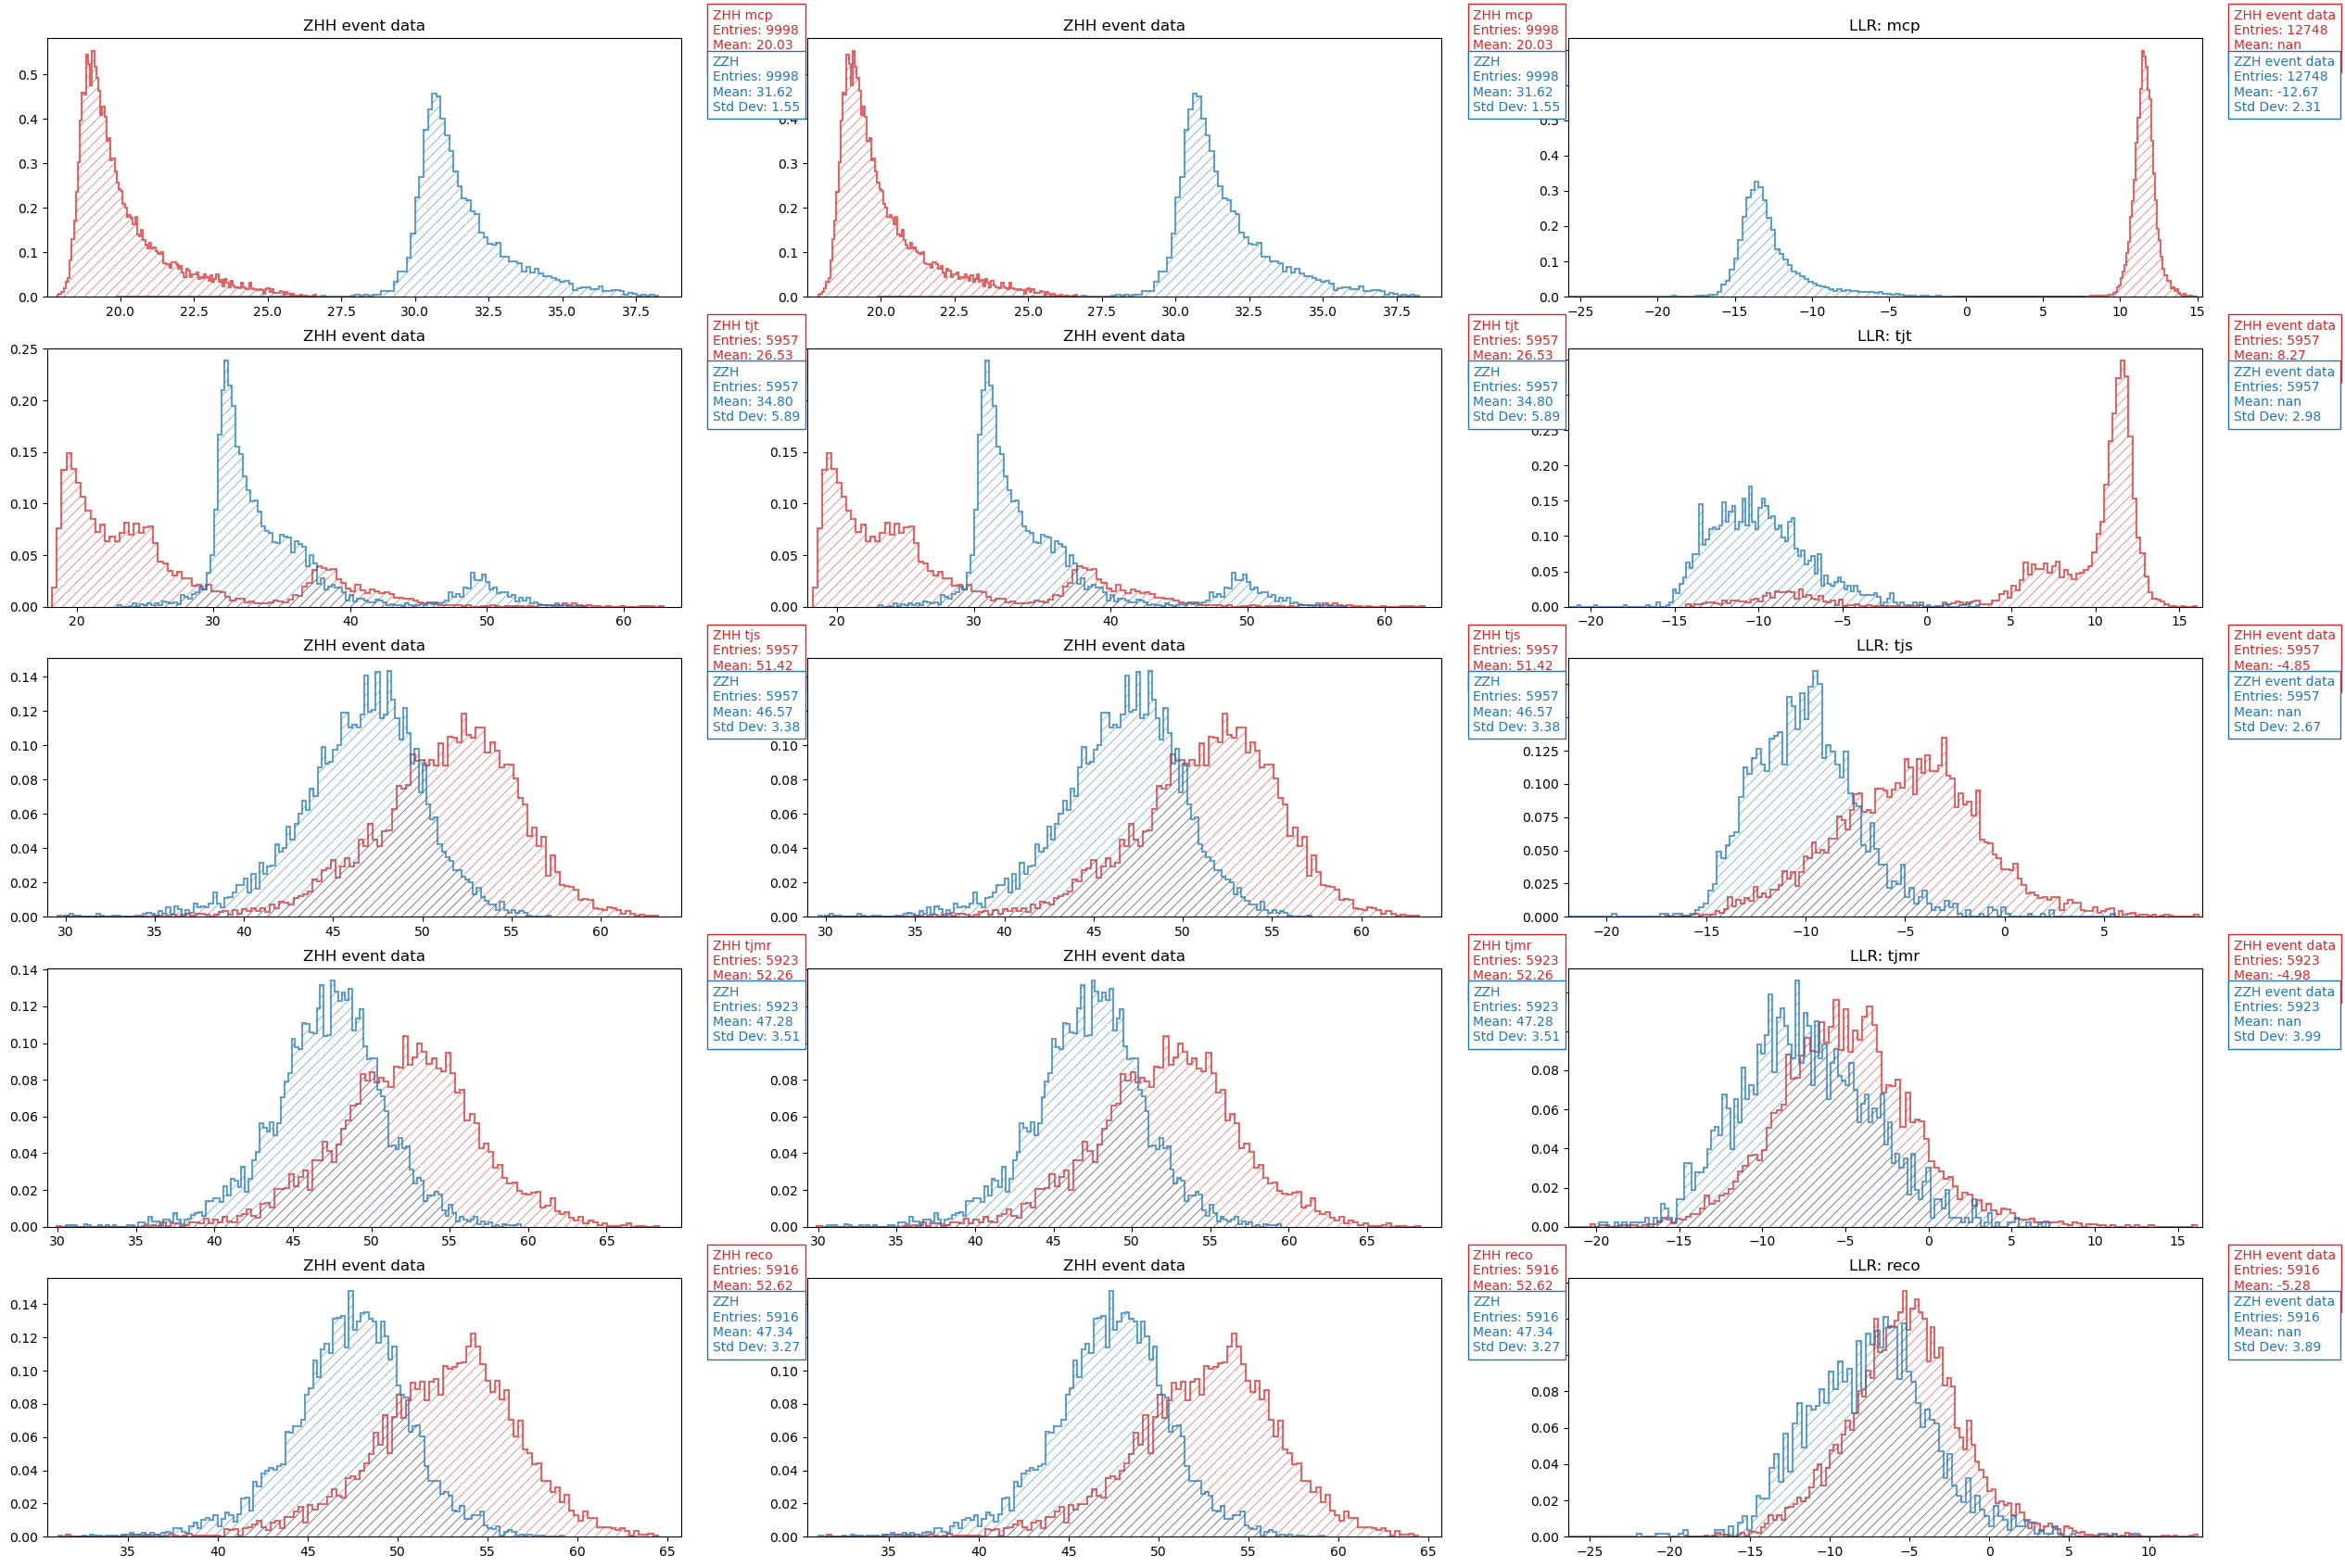

In [53]:
plot_nll_llr_dtf_delta(data)

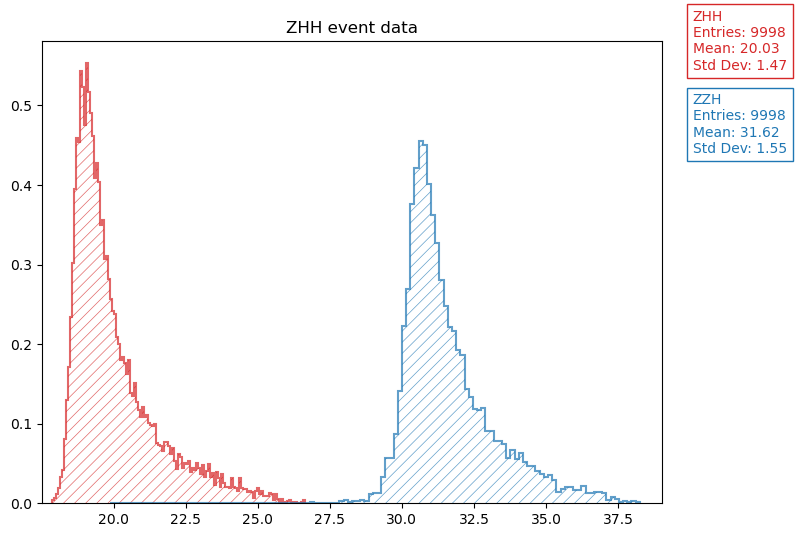

In [13]:
plot_llr_dtf_delta(mcp)

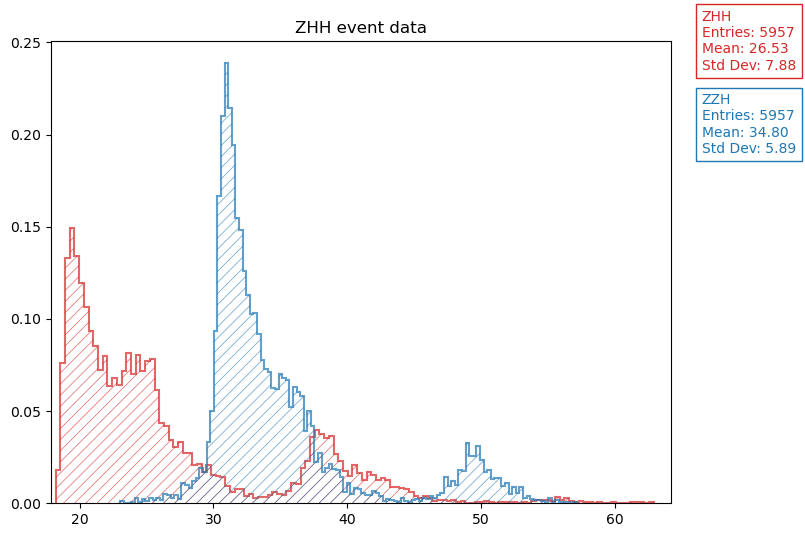

In [14]:
plot_llr_dtf_delta(tjt)

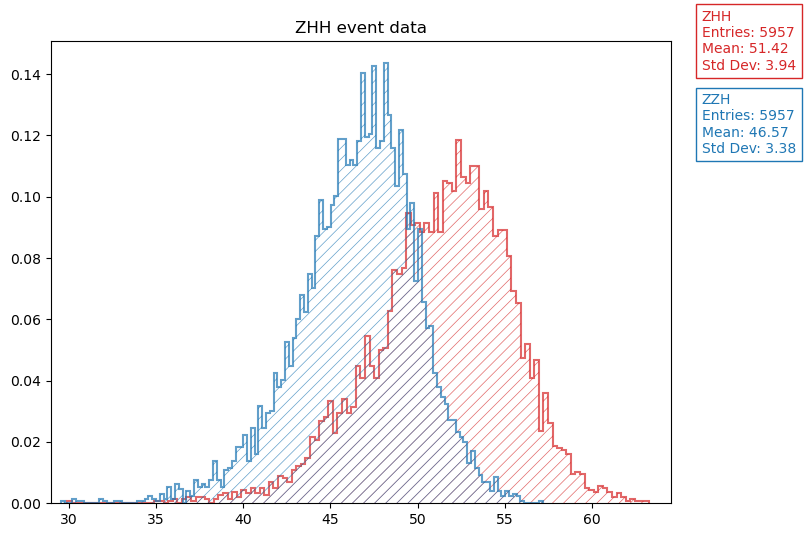

In [15]:
plot_llr_dtf_delta(tjs)

In [66]:
if False:
    import uproot as ur
    a = 0
    with ur.open("/nfs/dust/ilc/user/bliewert/fullflow_v3/zhh/root/rv02-02-03.sv02-02-03.mILD_l5_o1_v02_nobg.E500-TDR_ws.I403001.Pe2e2hh.eL.pR.n000.d_dstm_15807_0_MisclusteringSig.root") as file:
        a = ak.to_numpy(file["eventTree"]["recodijet_energy"].array())
        print(a)

ValueError: cannot convert to RegularArray because subarray lengths are not regular (in compiled code: https://github.com/scikit-hep/awkward/blob/awkward-cpp-15/awkward-cpp/src/cpu-kernels/awkward_ListOffsetArray_toRegularArray.cpp#L22)

In [3]:
production_mode      = False   # Switch the source and output directories accordingly
production_plot_mode = False  # Switch to either use ROOT (True) of matplotlib (False)
clear_output         = True  # Clear all existing output files before executing

source_path = "/nfs/dust/ilc/user/bliewert/fullflow_v3/comparison/root/prod" if production_mode else "/afs/desy.de/user/b/bliewert/public/MarlinWorkdirs/MEM_HEP/scripts/root/dev"
#source_path = join("/afs/desy.de/user/b/bliewert/public/MarlinWorkdirs/MEM_HEP/", "scripts") # getcwd()
output_path = join("/afs/desy.de/user/b/bliewert/public/MarlinWorkdirs/MEM_HEP/scripts/.npy", "prod" if production_mode else "dev")

if not is_linux:
    source_path = getcwd()
    output_path = join(getcwd(), ".npy")
    
if production_plot_mode:
    from analysis.plot_root import plot_hist
else:
    from analysis.plot_matplotlib import plot_hist

# Convert all .root files inside source_path to .npy files in output_path
# Note: Data in .root files is organized in a tree structure. We will use the name "dataTree" here
if clear_output:
    for abs_path in glob(join(output_path, "*.npy")):
        remove(abs_path)
    
n_conv = convert_directory(source_path, "dataTree", output_path)

files = list(map(lambda e: join(output_path, e), listdir(output_path)))
files.sort()
files

KeyInFileError: not found: 'dataTree' (with any cycle number)

    Available keys: (none!)

in file /nfs/dust/ilc/user/bliewert/fullflow_v3/comparison/root/prod/compare_reco.root

In [4]:
if production_plot_mode:
    from analysis.plot_root import plot_hist
else:
    from analysis.plot_matplotlib import plot_hist

In [5]:
# Import the complete generator-level(MCParticle)-, reconstruction-(reco) and truejet-datasets 
raw_mcparticle = import_data(files[0])
raw_reco       = import_data(files[1])
raw_truejet    = import_data(files[2])

# Filter the table to only contain entries without errors (error_code = 0) and with matrix elements > 0 for ZHH and ZZH (zhh_sigmalr and zzh_sigmalr)
data_mcparticle = filter_data(raw_mcparticle)
data_reco       = filter_data(raw_reco)
data_truejet    = filter_data(raw_truejet)

# Calculate the negative log likelihood based on the matrix elements 
data_mcparticle = calc_llr_dtf_delta(data_mcparticle)
data_reco       = calc_llr_dtf_delta(data_reco)
data_truejet    = calc_llr_dtf_delta(data_truejet)

In [38]:
data_mcparticle.dtypes["run"]

dtype('int32')

In [5]:
data_mcparticle.columns

Index(['run', 'event', 'error_code', 'is_zhh', 'is_zzh', 'passed_preselection',
       'true_h1_decay_pdg', 'true_h2_decay_pdg', 'true_z2_decay_pdg',
       'h1_decay_pdg', 'h2_decay_pdg', 'z2_decay_pdg', 'zhh_sigma',
       'zhh_sigmall', 'zhh_sigmalr', 'zhh_sigmarl', 'zhh_sigmarr', 'zhh_mz',
       'zhh_mhh', 'zhh_mzhh', 'zhh_phi', 'zhh_phif', 'zhh_phih',
       'zhh_costheta', 'zhh_costhetaf', 'zhh_costhetah', 'zzh_sigma',
       'zzh_sigmalll', 'zzh_sigmallr', 'zzh_sigmalrl', 'zzh_sigmalrr',
       'zzh_sigmarrr', 'zzh_sigmarrl', 'zzh_sigmarlr', 'zzh_sigmarll',
       'zzh_mz1', 'zzh_mz2', 'zzh_mzz', 'zzh_mzzh', 'zzh_mh', 'zzh_phi',
       'zzh_phiz', 'zzh_phiz1f', 'zzh_phiz2f', 'zzh_costheta', 'zzh_costhetaz',
       'zzh_costhetaz1f', 'zzh_costhetaz2f', 'zzh_sigmalr', 'true_type',
       'zhh_nll', 'zzh_nll', 'llr'],
      dtype='object')

In [323]:
c = root_to_numpy("C:\DevRepositories\MEM_HEP\compare_out.root", "dataTree", merge_with_np_array=a, join_by=["run", "event"], merge_columns=["zzh_h_e"])

('zzh_h_e', 'float32')


<Axes: xlabel='misclustering_region_icns', ylabel='count'>

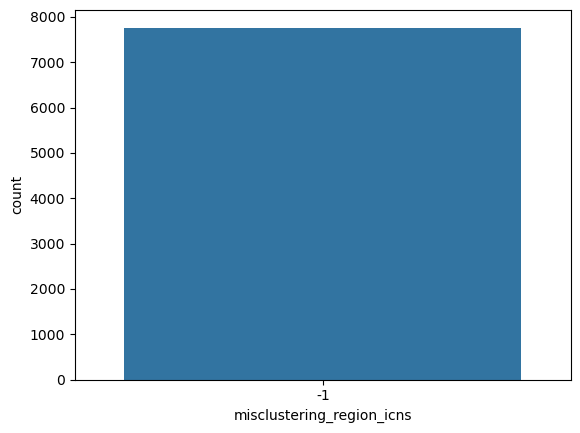

In [11]:
sns.countplot(data_reco, x="misclustering_region_icns")

<Axes: xlabel='efrac2_reco', ylabel='efrac2_true'>

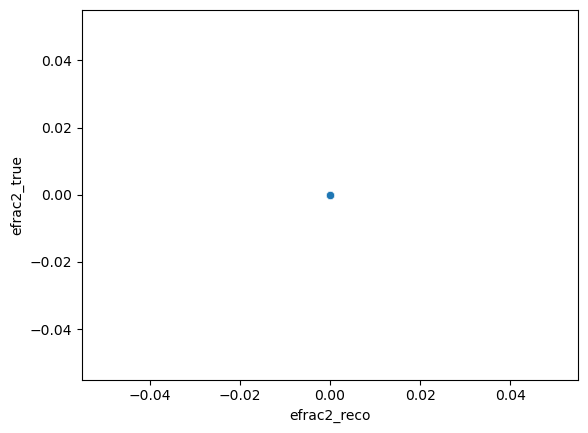

In [7]:
sns.scatterplot(data_reco, x="efrac1_reco", y="efrac1_true")

Comparing all (raw) and filtered (data) events

Text(0.5, 1.0, 'TrueJet / ZZH')

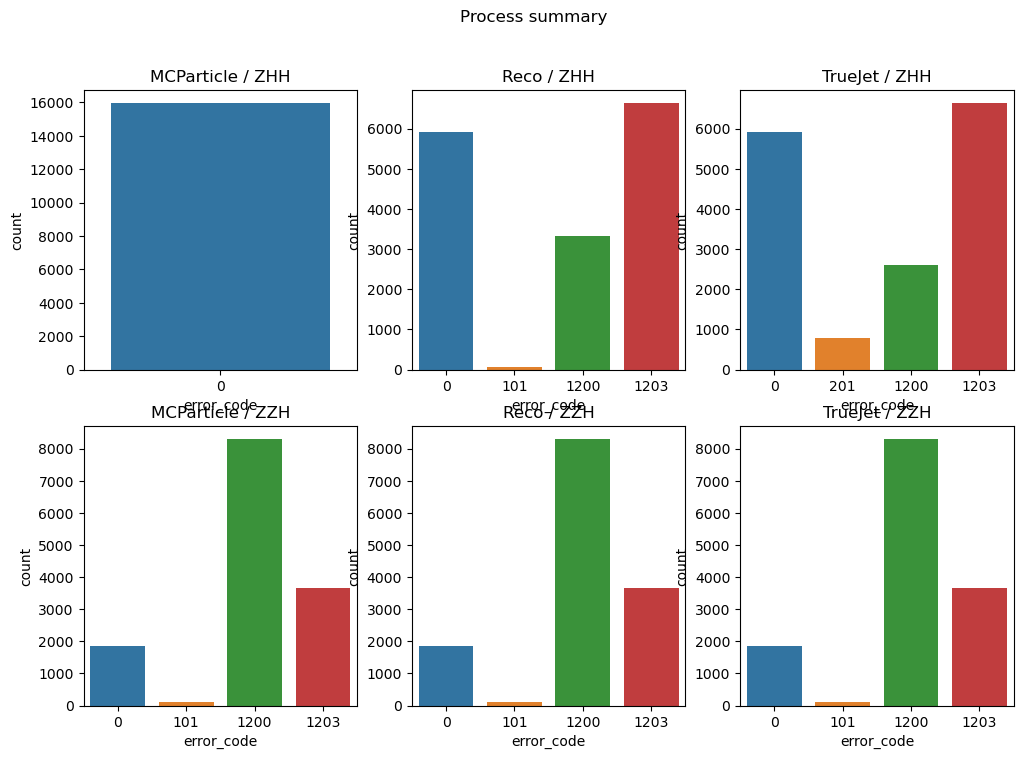

In [8]:
fig, ((ax11, ax12, ax13), (ax21, ax22, ax23)) = plt.subplots(2, 3, figsize=(12,8))
fig.suptitle("Process summary")

fig1 = sns.countplot(raw_mcparticle[raw_mcparticle["is_zhh"] == 1], x="error_code", ax=ax11)
fig1.set_title("MCParticle / ZHH")

fig2 = sns.countplot(raw_reco[raw_reco["is_zhh"] == 1], x="error_code", ax=ax12)
fig2.set_title("Reco / ZHH")

fig3 = sns.countplot(raw_truejet[raw_truejet["is_zhh"] == 1], x="error_code", ax=ax13)
fig3.set_title("TrueJet / ZHH")

fig4 = sns.countplot(raw_reco[raw_reco["is_zzh"] == 1], x="error_code", ax=ax21)
fig4.set_title("MCParticle / ZZH")

fig5 = sns.countplot(raw_reco[raw_reco["is_zzh"] == 1], x="error_code", ax=ax22)
fig5.set_title("Reco / ZZH")

fig6 = sns.countplot(raw_reco[raw_reco["is_zzh"] == 1], x="error_code", ax=ax23)
fig6.set_title("TrueJet / ZZH")

<Axes: xlabel='zzh_nll', ylabel='Count'>

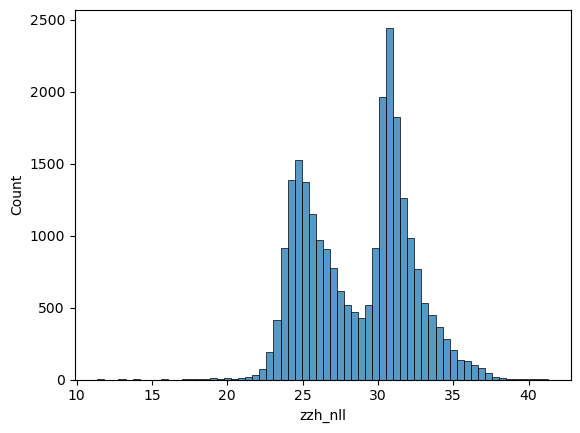

In [7]:
sns.histplot(data_mcparticle, x="zzh_nll", bins=64)

<Axes: xlabel='h1_decay_pdg', ylabel='count'>

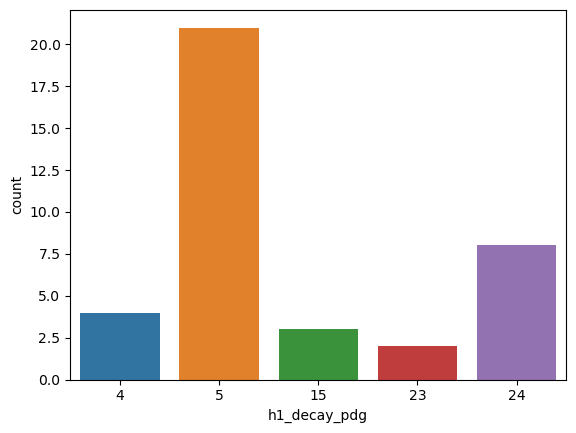

In [13]:
sns.countplot(data_mcparticle[(data_mcparticle["is_zzh"] == 1) & (data_mcparticle["error_code"] == 0)], x="h1_decay_pdg")

1. MCTruth

In [6]:
true_zzh = data_mcparticle[(data_mcparticle["is_zzh"] == 1) & (data_mcparticle["zhh_sigma"] > 0) & (data_mcparticle["zzh_sigma"] > 0)].copy()
true_zhh = data_mcparticle[(data_mcparticle["is_zhh"] == 1) & (data_mcparticle["zhh_sigma"] > 0) & (data_mcparticle["zzh_sigma"] > 0)].copy()

true_zzh.reset_index(drop=True,inplace=True)
true_zhh.reset_index(drop=True,inplace=True)

llr = combine_columns({ "zhh_llr": true_zhh["llr"], "zzh_llr": true_zzh["llr"] })

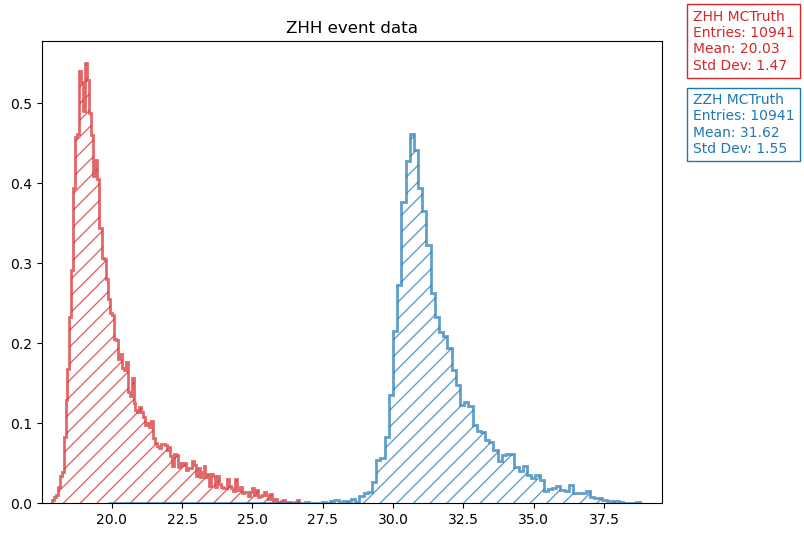

In [40]:
plot_hist(true_zhh, x = ["zhh_nll", "zzh_nll"], title="ZHH event data", normalize=True, labels=["ZHH MCTruth", "ZZH MCTruth"], xlabel="nll")

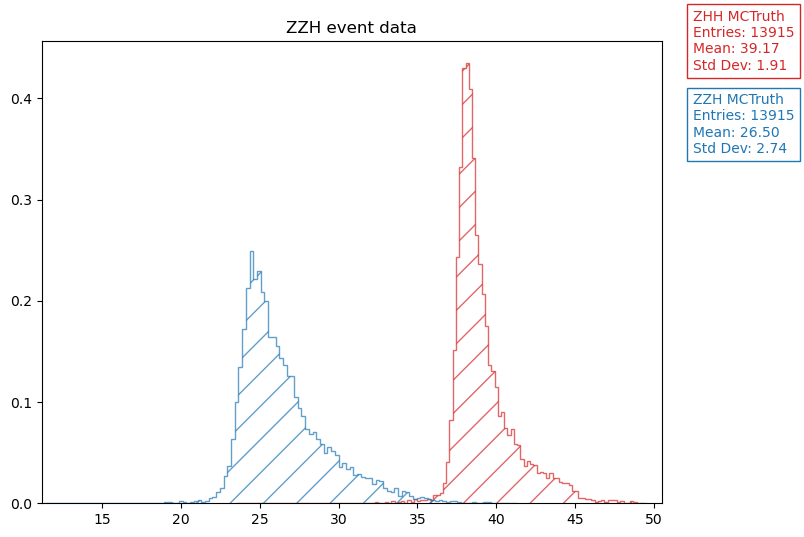

In [36]:
plot_hist(true_zzh, x = ["zhh_nll", "zzh_nll"], title="ZZH event data", normalize=True, labels=["ZHH MCTruth", "ZZH MCTruth"], xlabel="nll")

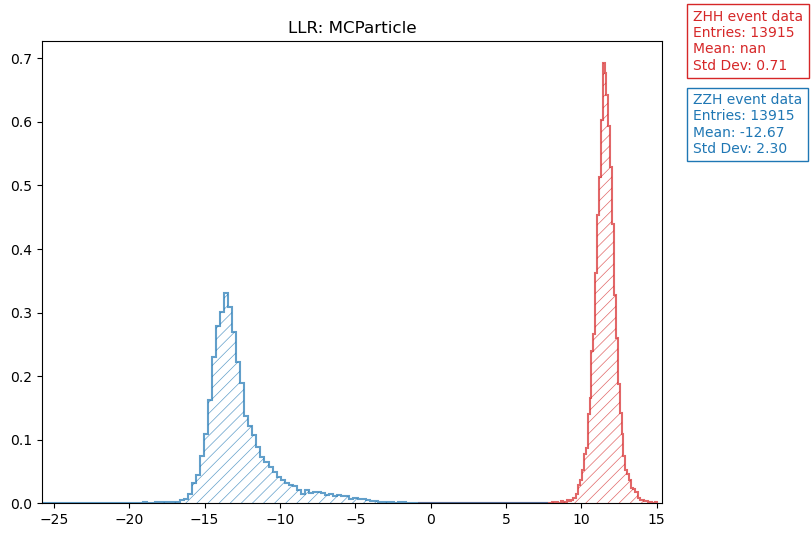

In [7]:
plot_hist(llr, x = ["zhh_llr", "zzh_llr"], labels=["ZHH event data", "ZZH event data"], title="LLR: MCParticle", normalize=True, xlabel="llr")

2. RefinedJets

In [55]:
true_zzh = data_reco[(data_reco["is_zzh"] == 1) & (data_reco["zhh_sigmalr"] > 0) & (data_reco["zzh_sigmalr"] > 0)].copy()
true_zhh = data_reco[(data_reco["is_zhh"] == 1) & (data_reco["zhh_sigmalr"] > 0) & (data_reco["zzh_sigmalr"] > 0)].copy()

true_zzh.reset_index(drop=True,inplace=True)
true_zhh.reset_index(drop=True,inplace=True)

llr = combine_columns({ "zhh_llr": true_zhh["llr"], "zzh_llr": true_zzh["llr"] })

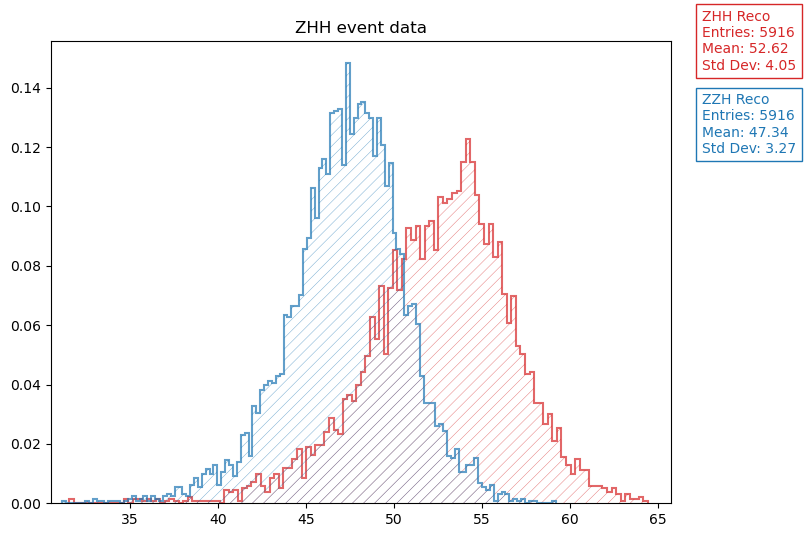

In [57]:
plot_hist(true_zhh, x = ["zhh_nll", "zzh_nll"], title="ZHH event data", normalize=True, labels=["ZHH Reco", "ZZH Reco"], xlabel="nll")

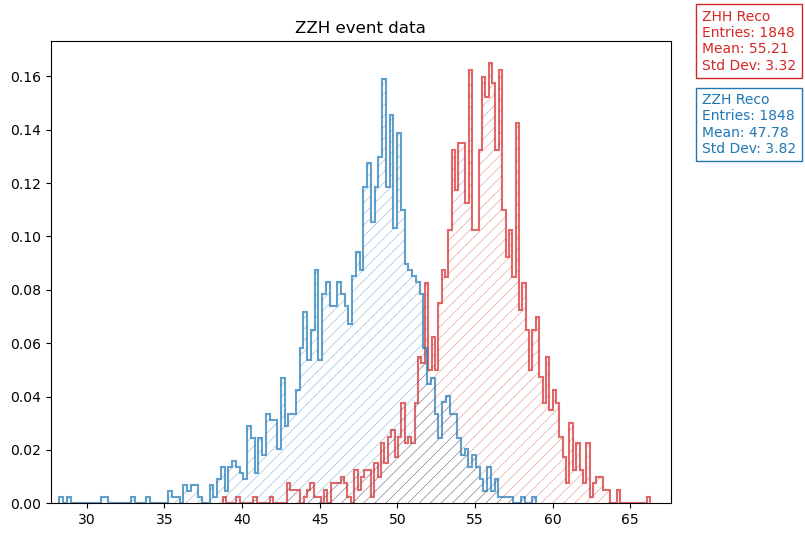

In [58]:
plot_hist(true_zzh, x = ["zhh_nll", "zzh_nll"], title="ZZH event data", normalize=True, labels=["ZHH Reco", "ZZH Reco"], xlabel="nll")

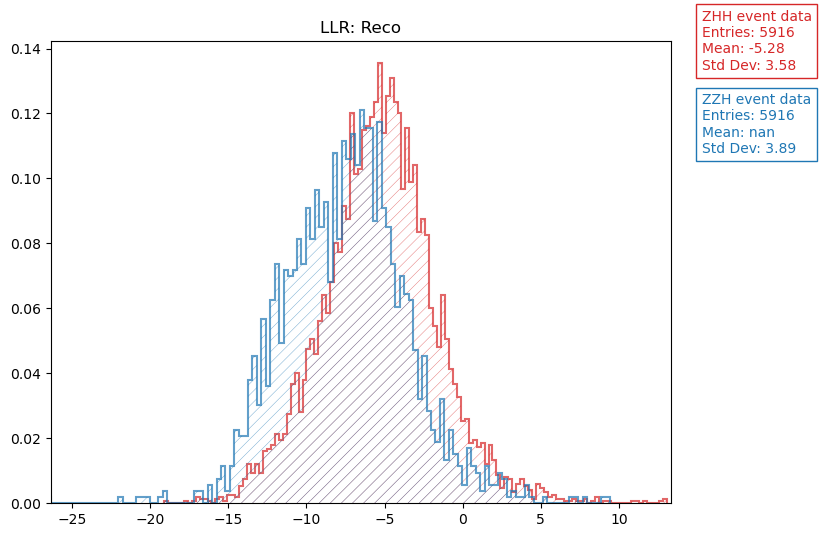

In [59]:
plot_hist(llr, x = ["zhh_llr", "zzh_llr"], labels=["ZHH event data", "ZZH event data"], title="LLR: Reco", normalize=True, xlabel="llr")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_name
Warning in <TROOT::Append>: Replacing existing TH1: ZHH event data (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: ZZH event data (Potential memory leak).


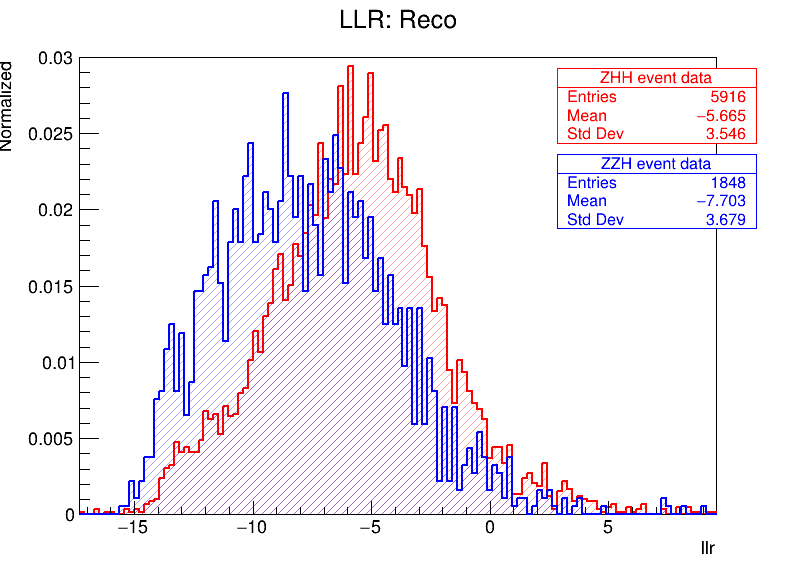

In [ ]:
plot_hist(llr, x = ["zhh_llr", "zzh_llr"], labels=["ZHH event data", "ZZH event data"], title="LLR: Reco", normalize=True, xlabel="llr")

3. TrueJet

In [60]:
true_zzh = data_truejet[(data_truejet["is_zzh"] == 1) & (data_truejet["zhh_sigmalr"] > 0) & (data_truejet["zzh_sigmalr"] > 0)].copy()
true_zhh = data_truejet[(data_truejet["is_zhh"] == 1) & (data_truejet["zhh_sigmalr"] > 0) & (data_truejet["zzh_sigmalr"] > 0)].copy()

true_zzh.reset_index(drop=True,inplace=True)
true_zhh.reset_index(drop=True,inplace=True)

llr = combine_columns({ "zhh_llr": true_zhh["llr"], "zzh_llr": true_zzh["llr"] })

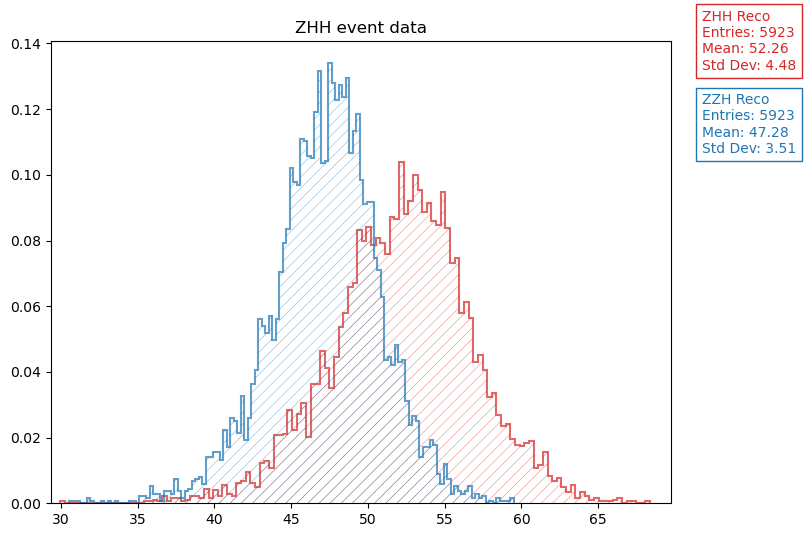

In [61]:
plot_hist(true_zhh, x = ["zhh_nll", "zzh_nll"], title="ZHH event data", normalize=True, labels=["ZHH Reco", "ZZH Reco"], xlabel="nll")

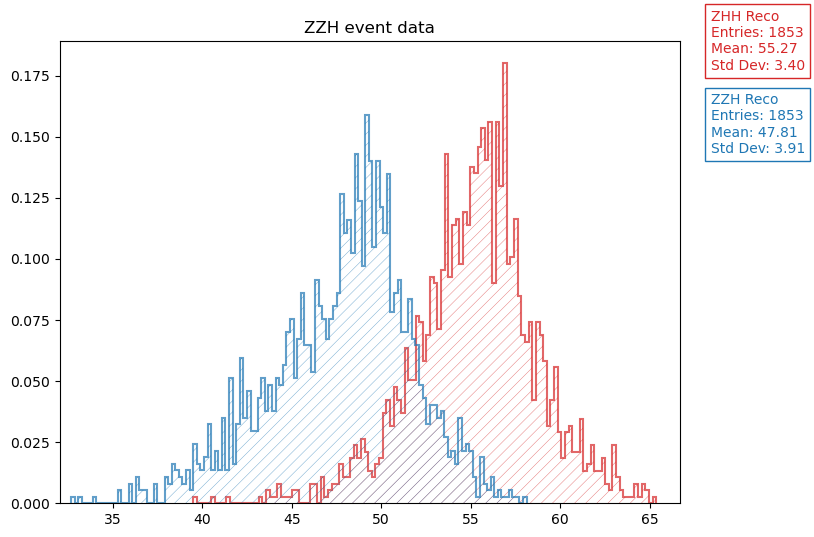

In [62]:
plot_hist(true_zzh, x = ["zhh_nll", "zzh_nll"], title="ZZH event data", normalize=True, labels=["ZHH Reco", "ZZH Reco"], xlabel="nll")

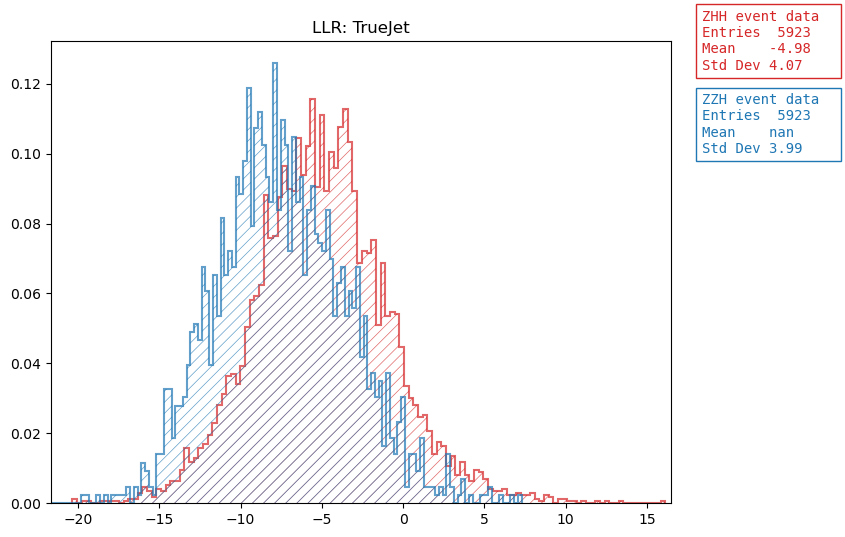

In [85]:
plot_hist(llr, x = ["zhh_llr", "zzh_llr"], labels=["ZHH event data", "ZZH event data"], title="LLR: TrueJet", normalize=True, xlabel="llr")

Region A

<Axes: xlabel='true_type', ylabel='count'>

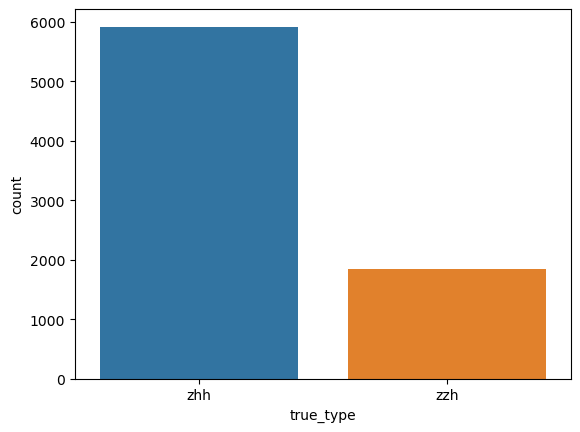

: 

In [ ]:
sns.countplot(data_reco, x="true_type")

<Axes: xlabel='misclustering_region_icns', ylabel='count'>

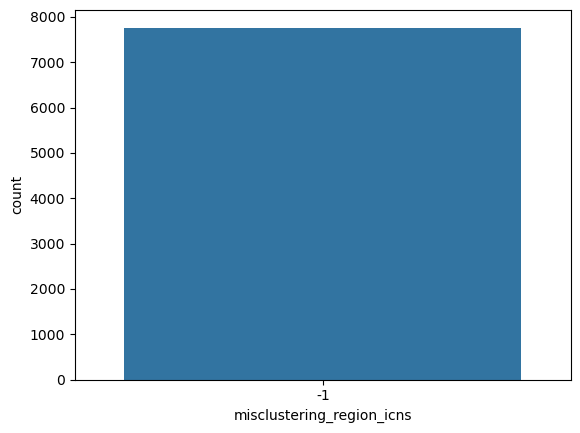

In [14]:
sns.countplot(data_reco, x="misclustering_region") # {"AA",0.}, {"AB",1.}, {"AC",2.}, {"AD",3.}, {"BB",4.}, {"BC",5.}, {"BD",6.}, {"CC",7.}, {"CD",8.}, {"DD",9.}

In [ ]:
data_reco.columns

Index(['run', 'event', 'error_code', 'is_zhh', 'is_zzh', 'passed_preselection',
       'true_h1_decay_pdg', 'true_h2_decay_pdg', 'true_z2_decay_pdg',
       'misclustering_region', 'misclustering_region_icns', 'h1_decay_pdg',
       'h2_decay_pdg', 'z2_decay_pdg', 'zhh_sigma', 'zhh_sigmall',
       'zhh_sigmalr', 'zhh_sigmarl', 'zhh_sigmarr', 'zhh_mz', 'zhh_mhh',
       'zhh_mzhh', 'zhh_phi', 'zhh_phif', 'zhh_phih', 'zhh_costheta',
       'zhh_costhetaf', 'zhh_costhetah', 'zzh_sigma', 'zzh_sigmalll',
       'zzh_sigmallr', 'zzh_sigmalrl', 'zzh_sigmalrr', 'zzh_sigmarrr',
       'zzh_sigmarrl', 'zzh_sigmarlr', 'zzh_sigmarll', 'zzh_mz1', 'zzh_mz2',
       'zzh_mzz', 'zzh_mzzh', 'zzh_mh', 'zzh_phi', 'zzh_phiz', 'zzh_phiz1f',
       'zzh_phiz2f', 'zzh_costheta', 'zzh_costhetaz', 'zzh_costhetaz1f',
       'zzh_costhetaz2f', 'zzh_sigmalr', 'true_type', 'zhh_nll', 'zzh_nll',
       'llr'],
      dtype='object')

In [8]:
misclustering_region = 0
data = data_reco

true_zzh = data[(data["is_zzh"] == 1) & (data["zhh_sigmalr"] > 0) & (data["zzh_sigmalr"] > 0) & (data["misclustering_region"] == misclustering_region)].copy()
true_zhh = data[(data["is_zhh"] == 1) & (data["zhh_sigmalr"] > 0) & (data["zzh_sigmalr"] > 0) & (data["misclustering_region"] == misclustering_region)].copy()

true_zzh.reset_index(drop=True,inplace=True)
true_zhh.reset_index(drop=True,inplace=True)

llr = combine_columns({ "zhh_llr": true_zhh["llr"], "zzh_llr": true_zzh["llr"] })

In [12]:
llr

,zhh_llr,zzh_llr


/nfs/dust/ilc/user/bliewert/.miniconda3/envs/py311/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/nfs/dust/ilc/user/bliewert/.miniconda3/envs/py311/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


ValueError: Axis limits cannot be NaN or Inf

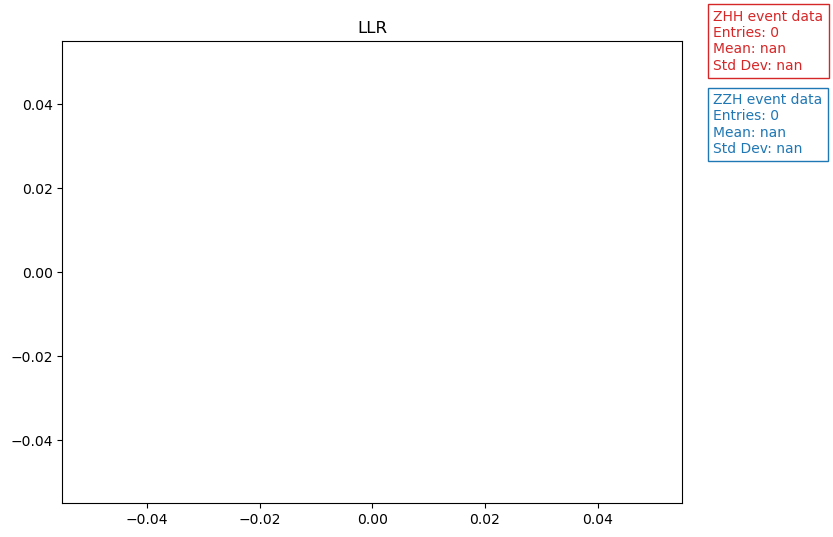

In [10]:
plot_hist(llr, x = ["zhh_llr", "zzh_llr"], labels=["ZHH event data", "ZZH event data"], title="LLR", normalize=True, xlabel="llr")